In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/DataIntelligenceApplications/')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.basic_generator import BasicDataGenerator
from environments.pricing_environment import PricingEnvironment
from environments.joint_environment import JointEnvironment
from learners.joint.thompson_sampling_Joint import ThompsonSampling
from learners.pricing.ucb import UCB
from learners.joint.GPTS_Learner_Joint import GPTS_Learner

In [3]:
data_gen = BasicDataGenerator(filename='src/basic001.json')
prices = data_gen.get_prices()
bids = data_gen.get_bids()
margins = data_gen.get_margins()
conv_rates = data_gen.get_conversion_rates(mode='aggregate')
n_clicks = data_gen.get_daily_clicks(mode='aggregate')
costs_per_click = data_gen.get_costs_per_click(mode='aggregate')
aggr_tau = data_gen.get_future_purchases(mode='aggregate')

print(15*'-','DATA', '-'*15)
print(f'prices={prices}')
print(f'bids={bids}')
print(f'margins={margins}')
print(f'conv_rates{conv_rates}')
print(f'cost_per_click={costs_per_click}')
print(f'n_clicks={n_clicks}')
print(f'aggr_tau={aggr_tau}')

n_arms = len(prices)
env_params = {
        'mode': 'aggregate',
        'src': 'src/basic001.json',
}

--------------- DATA ---------------
prices=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
bids=[0.03, 0.04, 0.07, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0]
margins=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
conv_rates[0.213 0.207 0.2   0.19  0.176 0.16  0.132 0.122 0.112 0.094]
cost_per_click=[0.03  0.04  0.069 0.097 0.189 0.44  0.626 0.796 1.1   1.367]
n_clicks=[ 28.807  37.296  59.959  79.058 124.63  183.261 199.824 206.816 211.296
 212.237]
aggr_tau=[2.85  2.485 2.12  1.755 1.39  1.025 0.84  0.69  0.65  0.65 ]


In [4]:
print('\n', 15 * '-', 'SIMULATION PARAMS', '-' * 15)
T = 200
n_experiments = 10
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')


 --------------- SIMULATION PARAMS ---------------
Time horizon: 200 days
Num. experiments: 10


In [5]:
opt_arm = np.argmax(margins * conv_rates * (1 + aggr_tau) - costs_per_click[3])
print(f'N_ARMS: {n_arms}')
print(f'Optimal arm: {str(opt_arm)}')

N_ARMS: 10
Optimal arm: 0


In [6]:
rewards_per_experiment = []
gpts_rewards_per_experiment = []


print(f'N_ROUNDS: {T}')
print(f'N_EXPERIMENTS: {n_experiments}')


N_ROUNDS: 200
N_EXPERIMENTS: 10


In [7]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'running experiment {e+1}/{n_experiments}...')
    test_instances = []
    ts_learner = ThompsonSampling(arm_values=margins)
    gpts_learner = GPTS_Learner(arms = bids)
    env = JointEnvironment(**env_params)

    for t in range(T):

        ts_learner.next_day()

        bidding_pulled_arm = gpts_learner.pull_arm()
        bidding_reward = env.bidding_round(bidding_pulled_arm)

        month_purchases = env.get_next_purchases_at_day(t, keep=False)
        if month_purchases is not None:
            pulled_arms = env.get_selected_arms_at_day(t - 30, keep=False)
            for arm, n_purchases in zip(pulled_arms, month_purchases):
                ts_learner.update_single_future_purchase(arm, n_purchases)
        pulled_arm = ts_learner.pull_arm()
        daily_reward = env.day_round(pulled_arm, bidding_reward['n_clicks'], bidding_reward['cpc'])
        #daily_reward = env.day_round(pulled_arm, n_clicks[3], costs_per_click[3])
        for outcome, cost in daily_reward:
            ts_learner.update(pulled_arm, outcome, cost)

        bidding_reward['tau'] = ts_learner.next_purchases_estimation[pulled_arm]
        bidding_reward['conv_rates'] = np.sum(daily_reward[:,0])/np.size(daily_reward[:,0])
        bidding_reward['margin'] = bidding_reward['margin'][pulled_arm]

        gpts_learner.update(bidding_pulled_arm, bidding_reward)

    rewards_per_experiment.append(ts_learner.daily_collected_rewards)
    gpts_rewards_per_experiment.append(gpts_learner.daily_collected_rewards)

running experiment 1/10...
arm = 8
passed reward dictionary {'n_clicks': 212.8500845282842, 'cpc': 1.1201754062397462, 'margin': 24, 'tau': 0.0, 'conv_rates': 0.07981220657276995}
calculated reward 169.2834080650361
arm = 0
passed reward dictionary {'n_clicks': 28.839220574577478, 'cpc': 0.029156865369779957, 'margin': 22, 'tau': 0.0, 'conv_rates': 0.1724137931034483}
calculated reward 108.54928573535568
arm = 0
passed reward dictionary {'n_clicks': 29.106269149564046, 'cpc': 0.030240282486653957, 'margin': 21, 'tau': 0.0, 'conv_rates': 0.10344827586206896}
calculated reward 62.35067876507891
arm = 5
passed reward dictionary {'n_clicks': 185.41461767150054, 'cpc': 0.43945352867161885, 'margin': 19, 'tau': 0.0, 'conv_rates': 0.15675675675675677}
calculated reward 470.75378030505084
arm = 9
passed reward dictionary {'n_clicks': 210.0313050792192, 'cpc': 1.3686724812080193, 'margin': 23, 'tau': 0.0, 'conv_rates': 0.11428571428571428}
calculated reward 264.61822018267134
arm = 6
passed rew

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


passed reward dictionary {'n_clicks': 185.2401608233083, 'cpc': 0.4351709807919622, 'margin': 15, 'tau': 2.9452736318407973, 'conv_rates': 0.21621621621621623}
calculated reward 2289.626010140504
passed reward dictionary {'n_clicks': 183.20852022617652, 'cpc': 0.43285320609547284, 'margin': 15, 'tau': 2.9452736318407973, 'conv_rates': 0.2786885245901639}
calculated reward 2942.270960605123
passed reward dictionary {'n_clicks': 184.47330720104299, 'cpc': 0.44200471208590414, 'margin': 15, 'tau': 2.9452736318407973, 'conv_rates': 0.17391304347826086}
calculated reward 1817.0645585597867
passed reward dictionary {'n_clicks': 186.19596732715058, 'cpc': 0.4364623619292667, 'margin': 15, 'tau': 2.8828451882845196, 'conv_rates': 0.21505376344086022}
calculated reward 2250.894132235488
passed reward dictionary {'n_clicks': 182.5786610607845, 'cpc': 0.4464648773408026, 'margin': 15, 'tau': 2.907749077490776, 'conv_rates': 0.16393442622950818}
calculated reward 1672.9233871970264
passed reward d

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


passed reward dictionary {'n_clicks': 182.4685000352529, 'cpc': 0.439363812115404, 'margin': 15, 'tau': 2.8279952550415204, 'conv_rates': 0.2087912087912088}
calculated reward 2107.4039817489725
passed reward dictionary {'n_clicks': 180.02187053748892, 'cpc': 0.44739436276304284, 'margin': 15, 'tau': 2.8286358511837677, 'conv_rates': 0.16111111111111112}
calculated reward 1585.118183161869
passed reward dictionary {'n_clicks': 184.98403681680276, 'cpc': 0.44286488075267055, 'margin': 15, 'tau': 2.8272138228941706, 'conv_rates': 0.1945945945945946}
calculated reward 1984.5942010200176
passed reward dictionary {'n_clicks': 184.16929711798727, 'cpc': 0.44232268729995583, 'margin': 15, 'tau': 2.8414006179196725, 'conv_rates': 0.19021739130434784}
calculated reward 1937.12865010892
passed reward dictionary {'n_clicks': 182.14805031168171, 'cpc': 0.4452110666479997, 'margin': 15, 'tau': 2.843098311817281, 'conv_rates': 0.23076923076923078}
calculated reward 2342.0271268031515
passed reward d

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


passed reward dictionary {'n_clicks': 184.23960783443636, 'cpc': 0.44649547669581763, 'margin': 16, 'tau': 2.5118483412322274, 'conv_rates': 0.15760869565217392}
calculated reward 1549.3574374925477
passed reward dictionary {'n_clicks': 181.98125305437836, 'cpc': 0.4378986683315656, 'margin': 15, 'tau': 2.8489089184060754, 'conv_rates': 0.17032967032967034}
calculated reward 1709.8689458933488
passed reward dictionary {'n_clicks': 184.59316698409006, 'cpc': 0.4450119271413994, 'margin': 15, 'tau': 2.8510237702988976, 'conv_rates': 0.22702702702702704}
calculated reward 2338.663485244926
passed reward dictionary {'n_clicks': 180.80807563613627, 'cpc': 0.4362525663204189, 'margin': 15, 'tau': 2.8510042036431607, 'conv_rates': 0.19889502762430938}
calculated reward 1998.4592286651591
passed reward dictionary {'n_clicks': 184.45263711355187, 'cpc': 0.43903652930142817, 'margin': 15, 'tau': 2.8504174397031585, 'conv_rates': 0.17391304347826086}
calculated reward 1771.7654693583659
passed re

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


passed reward dictionary {'n_clicks': 181.82489696154855, 'cpc': 0.44215948700663243, 'margin': 15, 'tau': 2.83091984499286, 'conv_rates': 0.1813186813186813}
calculated reward 1814.0852760183502
passed reward dictionary {'n_clicks': 180.5273937929248, 'cpc': 0.43680471601669846, 'margin': 15, 'tau': 2.8299292214357914, 'conv_rates': 0.20994475138121546}
calculated reward 2098.50428706296
passed reward dictionary {'n_clicks': 182.08410574548665, 'cpc': 0.4392162704037044, 'margin': 15, 'tau': 2.8274132048966467, 'conv_rates': 0.2802197802197802}
calculated reward 2849.34987240564
passed reward dictionary {'n_clicks': 187.37217290303445, 'cpc': 0.4317041548981409, 'margin': 15, 'tau': 2.8257228315054816, 'conv_rates': 0.21390374331550802}
calculated reward 2219.1127930463176
running experiment 6/10...
arm = 3
passed reward dictionary {'n_clicks': 79.72414346863432, 'cpc': 0.09748764474269372, 'margin': 21, 'tau': 0.0, 'conv_rates': 0.1375}
calculated reward 222.43134528979587
arm = 1
pa

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


passed reward dictionary {'n_clicks': 198.8980001408984, 'cpc': 0.6271303361159632, 'margin': 22, 'tau': 0.0, 'conv_rates': 0.135678391959799}
calculated reward 468.96056842785885
passed reward dictionary {'n_clicks': 214.22283512663168, 'cpc': 1.0788323817248429, 'margin': 17, 'tau': 0.0, 'conv_rates': 0.20093457943925233}
calculated reward 500.65064836220614
passed reward dictionary {'n_clicks': 207.66214941782877, 'cpc': 1.1103943360488673, 'margin': 18, 'tau': 0.0, 'conv_rates': 0.14903846153846154}
calculated reward 326.50677631676916
passed reward dictionary {'n_clicks': 213.5709032665671, 'cpc': 1.1059082787345567, 'margin': 21, 'tau': 0.8181818181818182, 'conv_rates': 0.14953271028037382}
calculated reward 983.1784537116387
passed reward dictionary {'n_clicks': 210.17071600928884, 'cpc': 1.090414136220145, 'margin': 17, 'tau': 3.2, 'conv_rates': 0.2}
calculated reward 2772.064704856607
passed reward dictionary {'n_clicks': 212.81604963353521, 'cpc': 1.124972746311678, 'margin':

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


passed reward dictionary {'n_clicks': 211.5504522516637, 'cpc': 1.1081659350295254, 'margin': 17, 'tau': 3.2, 'conv_rates': 0.2641509433962264}
calculated reward 3755.488355100334
passed reward dictionary {'n_clicks': 212.40093251681014, 'cpc': 1.0956945961837998, 'margin': 17, 'tau': 3.2, 'conv_rates': 0.19811320754716982}
calculated reward 2771.7447499386785
passed reward dictionary {'n_clicks': 207.80604087321166, 'cpc': 1.0965102634010697, 'margin': 17, 'tau': 3.2, 'conv_rates': 0.24519230769230768}
calculated reward 3410.142953172863
passed reward dictionary {'n_clicks': 209.60762814629675, 'cpc': 1.0783998315526016, 'margin': 17, 'tau': 3.2, 'conv_rates': 0.1619047619047619}
calculated reward 2197.0233504860835
passed reward dictionary {'n_clicks': 210.87976831420502, 'cpc': 1.0954503521516297, 'margin': 17, 'tau': 3.2, 'conv_rates': 0.1990521327014218}
calculated reward 2766.0829120723797
passed reward dictionary {'n_clicks': 211.30943100748516, 'cpc': 1.1096188964267213, 'margi

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


passed reward dictionary {'n_clicks': 207.01943076352745, 'cpc': 1.102103608191641, 'margin': 16, 'tau': 2.612244897959183, 'conv_rates': 0.21256038647342995}
calculated reward 2315.102255867961
passed reward dictionary {'n_clicks': 209.0198183492522, 'cpc': 1.102191116321378, 'margin': 15, 'tau': 3.0256410256410255, 'conv_rates': 0.22966507177033493}
calculated reward 2668.356597106781
passed reward dictionary {'n_clicks': 208.46935070951724, 'cpc': 1.1018145555377352, 'margin': 16, 'tau': 2.500000000000001, 'conv_rates': 0.23557692307692307}
calculated reward 2520.497253980308
passed reward dictionary {'n_clicks': 212.07211824487578, 'cpc': 1.0953630815503377, 'margin': 15, 'tau': 3.0256410256410255, 'conv_rates': 0.21226415094339623}
calculated reward 2485.9360981747413
passed reward dictionary {'n_clicks': 208.63970350149773, 'cpc': 1.1166807928211469, 'margin': 15, 'tau': 3.0256410256410255, 'conv_rates': 0.20574162679425836}
calculated reward 2359.0783219901205
passed reward dict

In [8]:
combined_opt = env.get_opt()
print(f'combined opt arm n°{env.get_opt_arm()}')
print(f'combined opt = {combined_opt}')

combined opt arm n°70
combined opt = 2379.366376


In [62]:
for exp in range(0,len(rewards_per_experiment)):
  rewards_per_experiment[exp] = rewards_per_experiment[exp][:199]

In [ ]:
rewards_per_experiment[0]

In [64]:
#MATCH SIZE
for exp in range(0,len(rewards_per_experiment)):
  rewards_per_experiment[exp] = np.append(rewards_per_experiment[exp],combined_opt)

print(len(rewards_per_experiment[0]))
print(len(gpts_rewards_per_experiment[0]))
print(rewards_per_experiment[0])
print(gpts_rewards_per_experiment[0])



200
200
[ 169.40263847  109.1544509    62.12303181  469.7010972   264.57877895
  422.59962606  493.70904022  517.40240594  401.96847256  611.75539163
  337.6386917   403.77035395  318.14961219  477.14082055  551.17198424
  432.3166325   459.18056047  518.75927781  530.04879043  213.82803036
  400.92329814  709.00576985  640.22520934  504.14625534  519.9135769
  531.33103209  659.94255995  477.20618432  106.52935862  418.58992836
  533.32073744  453.13787823  430.13376802 1342.64164833 1055.82986268
 1789.36558114 2488.98909701 2169.31834567 1814.02761101 2112.63405098
 1991.95151893 2052.60722562 1963.52782918 1872.97251287 2055.02758046
 2221.11510523 2112.27705968 2281.58179722 2397.66544129 1807.67230622
 1987.06247811 2395.88655637 1513.56546674 1406.41230702 1995.60569761
 2167.23205811 1991.61355095 2051.14077827 2525.40161469 2227.48494143
 2580.29181042 2050.26831949 1930.22718781 2287.09907385 2286.65754766
 2938.92219164 1812.40247626 2248.52511365 1676.78401232 2574.31520287

In [65]:
comb_rew = np.add(rewards_per_experiment, gpts_rewards_per_experiment)
print(comb_rew[0])

[ 338.68604654  217.70373664  124.47371057  940.4548775   529.19699913
  844.4863193   988.11210482 1033.98469245  804.00002443 1223.42059373
  674.47689054  806.62983599  636.94845394  955.56018912 1103.86197719
  865.05918488  918.63159641 1037.28314771 1059.87903654  428.04198831
  801.79556493 1419.26092214 1280.65456355 1007.25290244 1040.5324772
 1063.67957057 1320.44867014  953.6562281   213.89734638  837.13406447
 1065.21058289  906.30425395  861.09112712 2686.06851375 2109.36925919
 3577.0446557  4971.99841788 4339.41082293 3625.58162013 4219.83208111
 3980.08000592 4105.27824626 3925.95415772 3744.91329622 4108.92459846
 4436.71989894 4225.45602506 4569.26596121 4791.49381269 3611.36721723
 3976.0435184  4795.30936549 3029.81365692 2815.35133798 3987.05508962
 4339.10588706 3982.80723466 4097.41609132 5052.5041623  4456.67641178
 5162.66917871 4098.9256298  3861.32285348 4577.73274496 4576.2835578
 5881.19315225 3629.46703482 4499.41924589 3349.70739951 5145.0970048
 3356.166

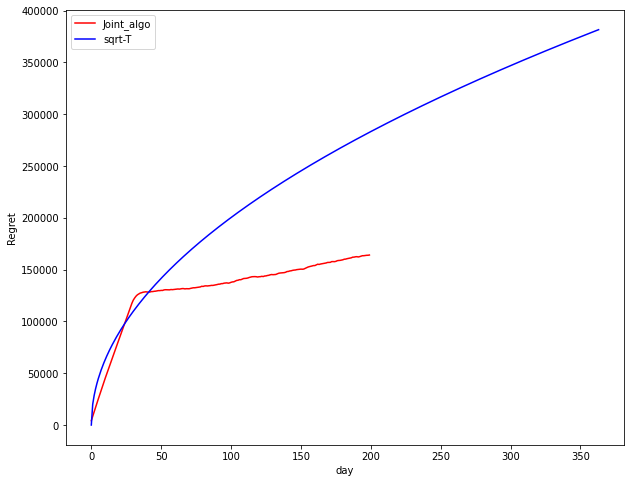

In [76]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
#opt = (margins[opt_arm] * conv_rates[opt_arm] * (1 + aggr_tau[opt_arm]) - costs_per_click[3]) * np.rint(n_clicks[3]).astype(int)
plt.plot(np.cumsum(np.mean(2*combined_opt - comb_rew, axis=0)), 'r')
plt.plot(20000*np.sqrt(np.linspace(0,364,364)), 'b')
plt.legend(['Joint_algo', 'sqrt-T'])
plt.show()

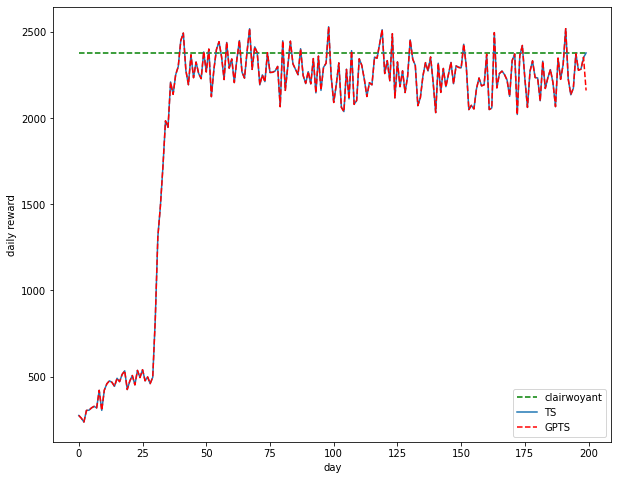

In [74]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([combined_opt]*T, '--g', label='clairwoyant')
plt.plot(np.mean(rewards_per_experiment, axis=0), label='TS')
plt.plot(np.mean(gpts_rewards_per_experiment, axis=0),'--r' ,label='GPTS')
plt.legend(loc='best')
plt.show()